# Analysis of 77036 zip code

## Imports and loading csv

In [116]:
#Imports
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
register_matplotlib_converters()

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from scipy import stats
from random import gauss as gs
import datetime

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

#Supress default INFO logging
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import logging, sys
warnings.simplefilter(action='ignore', category=FutureWarning)

In [117]:
df = pd.read_csv('Data Files/df_zillow_77036_prepped_fbprophet.csv')

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      265 non-null    object 
 1   y       265 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.3+ KB


## Decomposition and plots

In [119]:
df.index = pd.to_datetime(df['ds'])
df= df.drop(columns='ds')

In [120]:
decomposition = seasonal_decompose(df.y)
observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [121]:
register_matplotlib_converters()

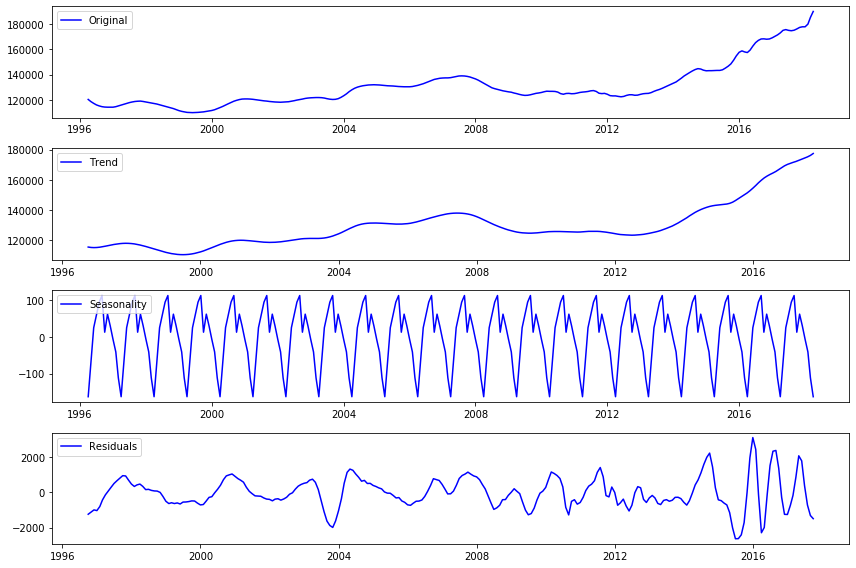

In [122]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(observed, label='Original', color="blue")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='upper left')
plt.tight_layout()

## I want to see if the data correlates with earlier data of itself

1) Get rolling average with window of 4
    - Couldn't see much with window of 1-3

2) Plot data against itself with rolling avg to see visual of the graph. 

In [123]:
df.rolling(window=2).mean().head()

,y
ds,
1996-04-01,NaN
1996-05-01,119550.0
1996-06-01,118000.0
1996-07-01,116700.0
1996-08-01,115700.0


In [124]:
df['roll_avg'] = df.rolling(window=4).mean()
df.corr()

,y,roll_avg
y,1.000000,0.997956
roll_avg,0.997956,1.000000


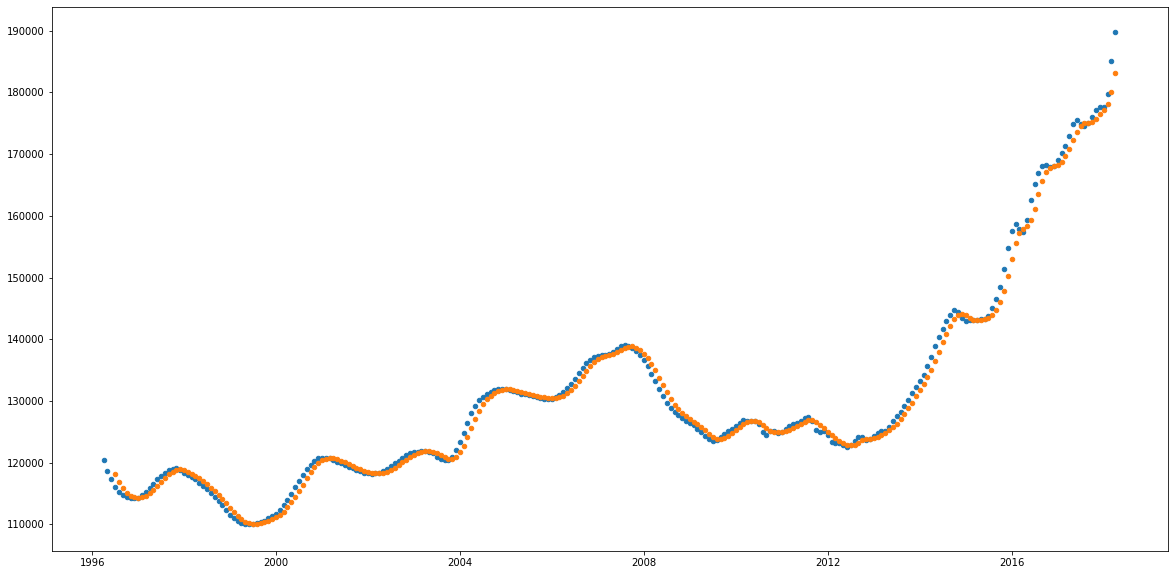

In [125]:
plt.figure(figsize=(20, 10))
plt.scatter(df.index[:265], df['y'][:265], s=20)
plt.scatter(df.index[1:265], df['roll_avg'][1:265], s=20);

In [126]:
lr = LinearRegression()
lr.fit(df[['roll_avg']][4:], df['y'][4:])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

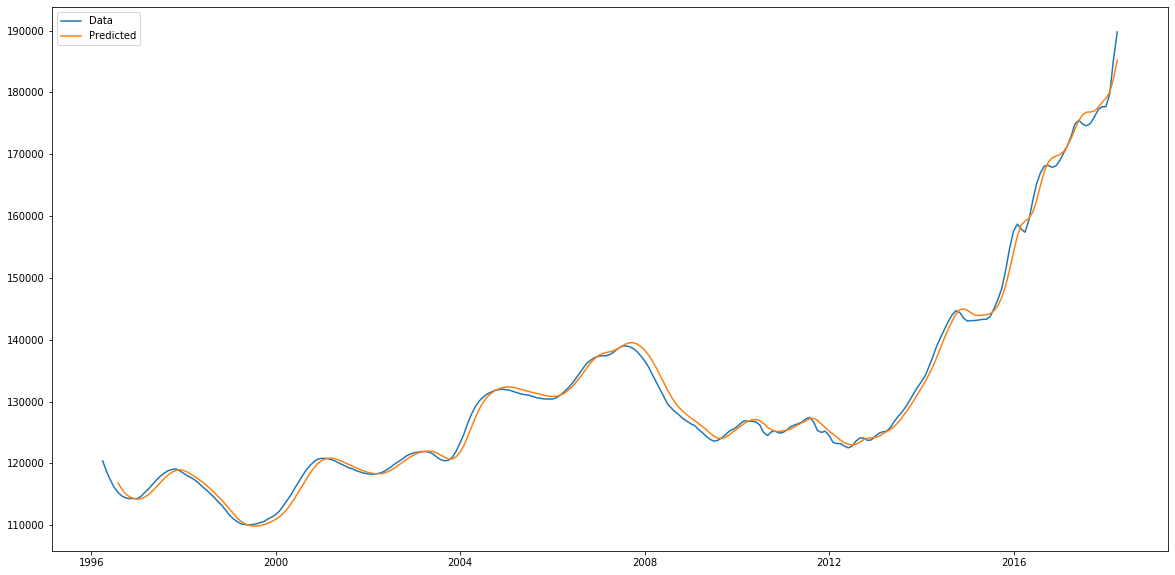

In [127]:
plt.figure(figsize=(20, 10))
plt.plot(df.index[:265], df['y'][:265], label='Data')
plt.plot(df.index[4:265], lr.predict(df[['roll_avg']][4:265]),
         label='Predicted')
plt.legend();

### Upon brief visual look, there might be some correlation. We will set up for our model by using the Dickey-Fuller test and ACF (Auto-correlation) and PACF (Partial-autocorrelation)

# Checking for Stationarity

In [128]:
dftest = adfuller(df.y)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print()
print(dfoutput)

(2.5951808760954007, 0.9990742482499826, 10, 254, {'1%': -3.456360306409983, '5%': -2.8729872043802356, '10%': -2.572870232500465}, 3610.435651357008)

Test Statistic                   2.595181
p-value                          0.999074
#Lags Used                      10.000000
Number of Observations Used    254.000000
Critical Value (1%)             -3.456360
Critical Value (5%)             -2.872987
Critical Value (10%)            -2.572870
dtype: float64


#### Dickey Fuller Test 
    - We see that test statistic value is -1.052638
    - We see that the critical values are LESS than the test statistic. (-3.45, -2.87, -2.57)
    - From just the baseline data, the test statistic I have is MORE than the critical value. 
    - We accept the null that the time series is not stationary!
    

#### P-Value analysis
1. If p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    - Our current p-value is 0.733585
        - This means: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    
    
2. If p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
     - Our goal is to make the data stationary

## Auto-Correlation and Partial Auto-Correlation Check

In [129]:
acf(df['y'], nlags=20, fft=False)

array([1.        , 0.97331676, 0.94772254, 0.9246598 , 0.90195886,
       0.87799812, 0.85327676, 0.82855234, 0.80384665, 0.77878522,
       0.75282159, 0.72580341, 0.6989086 , 0.67345552, 0.64911133,
       0.62535174, 0.60218753, 0.57936398, 0.55631544, 0.53263342,
       0.50862147])

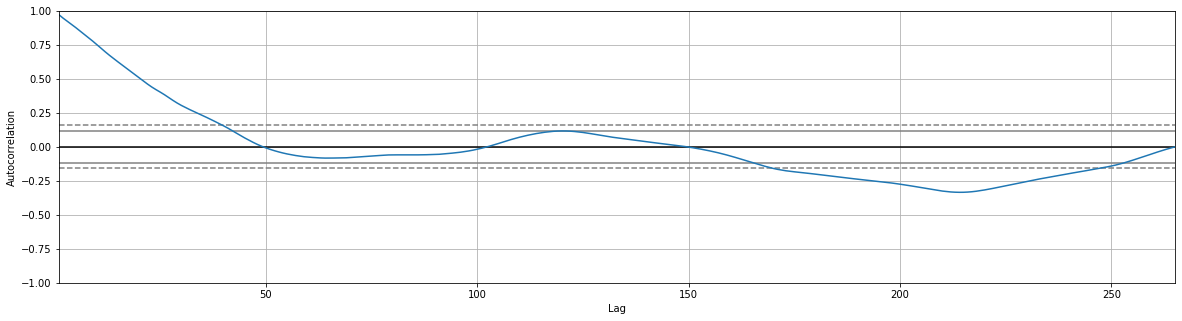

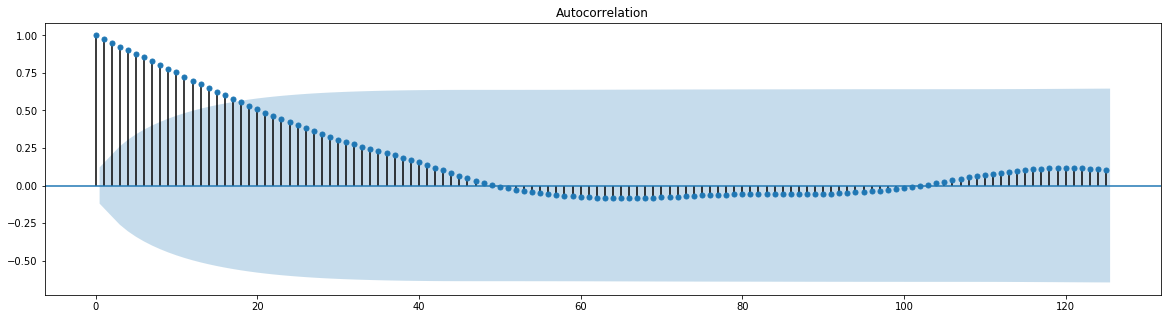

In [130]:
#ACF using plotting
plt.figure(figsize=(20, 5))
pd.plotting.autocorrelation_plot(df['y']);

#Statsmodels ACF
rcParams['figure.figsize'] = 20, 5
plot_acf(df['y'], lags=125, alpha=0.05);

## PACF

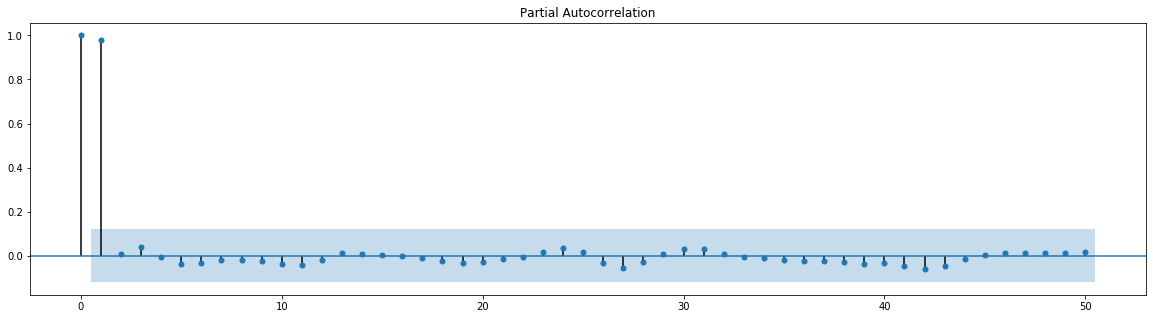

In [131]:
pacf(df['y'], nlags=20)
rcParams['figure.figsize'] = 20, 5
plot_pacf(df['y'], lags=50, alpha=0.05);

## Observations of ACF and PACF

## We see the following:

 - We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.
         - After about 18 lags, the line goes into our confidence interval (light blue area). 
         - This can be due to seasonality of every 18 months in our data.


 - We know that the PACF only describes the direct relationship between an observation and its lag.
         - PACF cuts off after lags = 2
         - This means there are no correlations for lags beyond 2
         
## ** Granted the data is not stationary, we will have to transform the data to make it stationary and satisfy the Dicky-Fuller test**

# De-trending and transforming the data
1. I will try the following
    - Log transform
    - Subtract rolling mean
    - Run Dickey-Fuller test with each transform to see if I can rejefct/accept the null hypothesis
    - Null-Hypothesis for Dickey-Fuller test is: The null-hypothesis for the test is that the time series is not stationary. So if the test statistic is less than the critical value, we reject the null hypothesis and say that the series is stationary. 

## Log-transform on data and testing for stationarity

In [132]:
logged_df = df['y'].apply(lambda x : np.log(x))

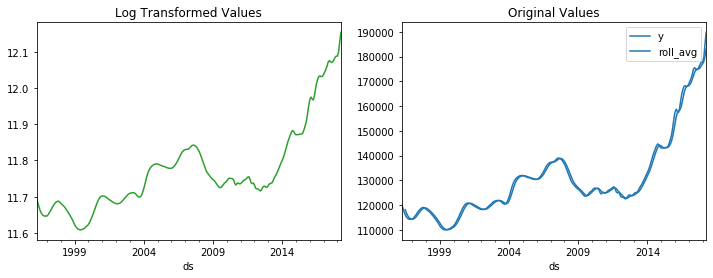

In [133]:
ax1 = plt.subplot(121)
logged_df.plot(figsize=(12,4) ,color="tab:green", title="Log Transformed Values", ax=ax1);
ax2 = plt.subplot(122)
df.plot(color="tab:blue", title="Original Values", ax=ax2);

In [134]:
dftest = adfuller(logged_df)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print()
print(dfoutput)

(2.0832025283959608, 0.9987717754068696, 10, 254, {'1%': -3.456360306409983, '5%': -2.8729872043802356, '10%': -2.572870232500465}, -2279.921341518233)

Test Statistic                   2.083203
p-value                          0.998772
#Lags Used                      10.000000
Number of Observations Used    254.000000
Critical Value (1%)             -3.456360
Critical Value (5%)             -2.872987
Critical Value (10%)            -2.572870
dtype: float64


## Observations after log-transform

1. Test Statistic is still larger than Critical Values. We accept the null-hypothesis that the time series is not stationary!

    - Test Statistic                  2.083203
    - Critical Value (1%)             -3.456360
    - Critical Value (5%)             -2.872987
    - Critical Value (10%)            -2.572870
    

2. P value is 0.998772
    - This means: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

## Subtracting Rolling Mean from logged data and a better window size

In [135]:
#Try breakdown with data minus rollmean. It looks like there is seasonality but I want to try with roll mean removed
# Window of 11 

logged_df_roll_mean = logged_df.rolling(window=11).mean()
logged_df_minus_roll_mean1 = logged_df - logged_df_roll_mean
logged_df_minus_roll_mean1.dropna(inplace=True)

In [136]:
logged_df_minus_roll_mean1.head()

ds
1997-02-01   -0.009949
1997-03-01   -0.000797
1997-04-01    0.006563
1997-05-01    0.013129
1997-06-01    0.018180
Name: y, dtype: float64

In [137]:
dftest = adfuller(logged_df_minus_roll_mean1)
# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print()
print(dfoutput)

(-3.4770410156712814, 0.00859668227689364, 4, 250, {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}, -2225.30032373215)

Test Statistic                  -3.477041
p-value                          0.008597
#Lags Used                       4.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


## --- Observations from Dickey Fuller Test ---
### Hmmm 
    -Test statistic is -3.477041 which is lower than crit values
    -p value is 0.008597
        - I can reject null hypothesis since p<0.05

## ACF and PACF

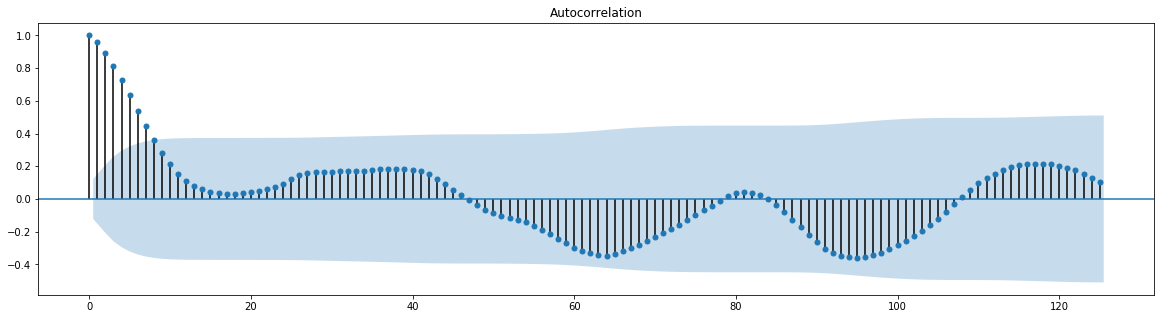

In [138]:
#Statsmodels ACF
rcParams['figure.figsize'] = 20, 5
plot_acf(logged_df_minus_roll_mean1, lags=125, alpha=0.05);

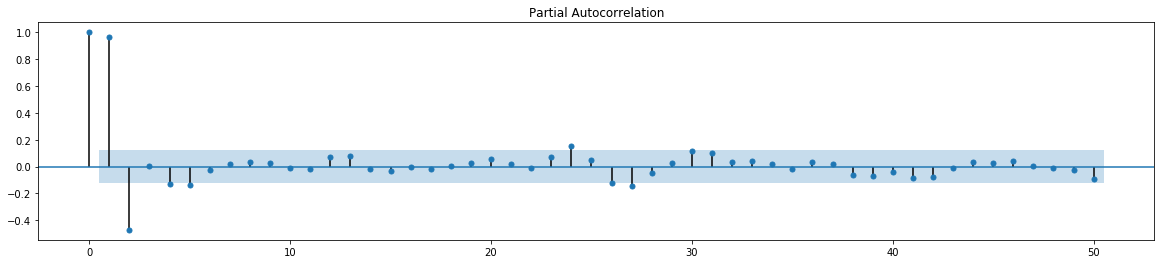

In [139]:
#PACF plot
rcParams['figure.figsize'] = 20, 4
plot_pacf(logged_df_minus_roll_mean1, lags=50, alpha=0.05);

## --- Observations of ACF and PACF ---

1. After about 8-9 lags, the line goes into our confidence interval (light blue area). 
    - This can be due to seasonality of every 8-9 months in our data.
    
2. PACF trails off after 2-3 lags.
    - Also slight slight sinusoidal behavior but nothing crazy
    - This means there are no high correlations for lags beyond 2-3
    
    
3. Based on above information and that the data is stationary, we can use the p and q values for the ARMA model
     - p = 8 or 9 (per ACF)
     - q = 2 (per PACF)

## ARMA Modeling

In [140]:
# Instantiate & fit model with statsmodels
#p = num lags - ACF
p = 8

 # q = lagged forecast errors - PACF
q = 2

# Fitting ARMA model and summary
ar = ARMA(logged_df_minus_roll_mean1,(p, q)).fit()
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  255
Model:                     ARMA(8, 2)   Log Likelihood                1203.228
Method:                       css-mle   S.D. of innovations              0.002
Date:                Thu, 29 Apr 2021   AIC                          -2382.456
Time:                        14:13:18   BIC                          -2339.961
Sample:                    02-01-1997   HQIC                         -2365.362
                         - 04-01-2018                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0096      0.006      1.701      0.090      -0.001       0.021
ar.L1.y        1.8670      0.363      5.142      0.000       1.155       2.579
ar.L2.y       -1.4106      0.749     -1.884      0.061      -2.878       0.057
ar.L3.y        0.7428      0.761      0.976      0.330      -0.748       2.234
ar.L4.y       -0.0625      0.631     -0.099      0.921      -1.299       1.174
ar.L5.y       -0.3861      0.455     -0.848      0.397      -1.278       0.506
ar.L6.y        0.4087      0.324      1.260      0.209      -0.227       1.045
ar.L7.y       -0.3562      0.202     -1.765      0.079      -0.752       0.039
ar.L8.y        0.1544      0.083      1.857      0.065      -0.009       0.317
ma.L1.y        0.6347      0.365      1.738      0.083      -0.081       1.350
ma.L2.y        0.2041      0.291      0.701      0.484      -0.366       0.775
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3272           -0.0000j            1.3272           -0.5000
AR.2           -0.3641           -1.2886j            1.3390           -0.2938
AR.3           -0.3641           +1.2886j            1.3390            0.2938
AR.4            0.4485           -1.2037j            1.2846           -0.1932
AR.5            0.4485           +1.2037j            1.2846            0.1932
AR.6            1.1496           -0.3046j            1.1893           -0.0412
AR.7            1.1496           +0.3046j            1.1893            0.0412
AR.8            1.1663           -0.0000j            1.1663           -0.0000
MA.1           -1.5551           -1.5754j            2.2136           -0.3740
MA.2           -1.5551           +1.5754j            2.2136            0.3740
-----------------------------------------------------------------------------
"""

In [141]:
r2_score(logged_df_minus_roll_mean1, ar.predict())

0.9868885612980828

 - Ths means that 98.689 percent of the variation in the y data is due to variation in the x data
 - This might indicate overfitting, but we chose our params from a stationary time series ACF and PACF.
    
    -Future work: investigate more tweaks to the model

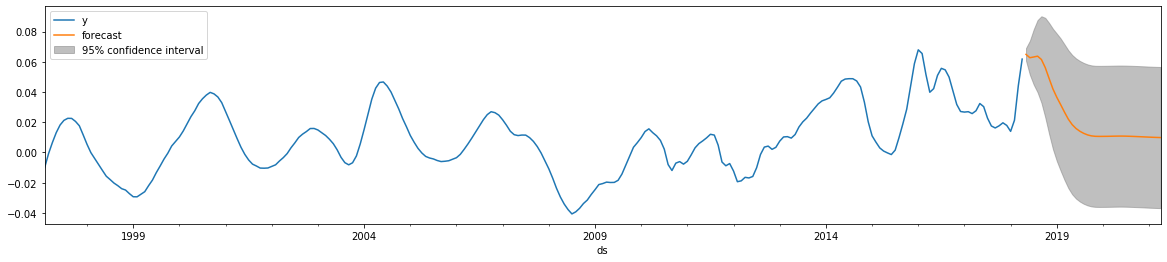

In [142]:
#plot of ARMA model
fig, ax = plt.subplots()
ax = logged_df_minus_roll_mean1.plot(ax=ax)
fig = ar.plot_predict('2018-05-01', '2021-04-01', dynamic=True, ax=ax, plot_insample=False)
plt.show()

### Change the params, maybe it will affect r^2

In [147]:
# Try p = 9 and q = 3


# Instantiate & fit model with statsmodels
#p = num lags - ACF
p = 9

 # q = lagged forecast errors - PACF
q = 2

# Fitting ARMA model and summary
ar = ARMA(logged_df_minus_roll_mean1,(p, q)).fit()
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  255
Model:                     ARMA(9, 2)   Log Likelihood                1203.074
Method:                       css-mle   S.D. of innovations              0.002
Date:                Thu, 29 Apr 2021   AIC                          -2380.148
Time:                        14:13:43   BIC                          -2334.112
Sample:                    02-01-1997   HQIC                         -2361.630
                         - 04-01-2018                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0096      0.006      1.674      0.095      -0.002       0.021
ar.L1.y        1.1114      0.298      3.730      0.000       0.527       1.695
ar.L2.y        0.2631      0.492      0.535      0.593      -0.701       1.228
ar.L3.y       -0.8283      0.257     -3.218      0.001      -1.333      -0.324
ar.L4.y        0.8485      0.226      3.749      0.000       0.405       1.292
ar.L5.y       -0.5245      0.304     -1.726      0.086      -1.120       0.071
ar.L6.y        0.0082      0.269      0.031      0.976      -0.518       0.535
ar.L7.y        0.1397      0.145      0.961      0.338      -0.145       0.425
ar.L8.y       -0.2318      0.119     -1.943      0.053      -0.466       0.002
ar.L9.y        0.1503      0.075      2.006      0.046       0.003       0.297
ma.L1.y        1.3881      0.297      4.678      0.000       0.807       1.970
ma.L2.y        0.4150      0.258      1.608      0.109      -0.091       0.921
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0438           -0.0000j            1.0438           -0.5000
AR.2           -1.2828           -0.0000j            1.2828           -0.5000
AR.3           -0.2689           -1.3503j            1.3768           -0.2813
AR.4           -0.2689           +1.3503j            1.3768            0.2813
AR.5            0.5096           -1.1964j            1.3004           -0.1859
AR.6            0.5096           +1.1964j            1.3004            0.1859
AR.7            1.1237           -0.3121j            1.1663           -0.0431
AR.8            1.1237           +0.3121j            1.1663            0.0431
AR.9            1.1395           -0.0000j            1.1395           -0.0000
MA.1           -1.0501           +0.0000j            1.0501            0.5000
MA.2           -2.2947           +0.0000j            2.2947            0.5000
-----------------------------------------------------------------------------
"""

In [148]:
#r^2 is slightly lower but no real change. Could be overfitting. We did log and removed rolling mean to make it stationary.
r2_score(logged_df_minus_roll_mean1, ar.predict())

0.9868611751840894

### Forecasting

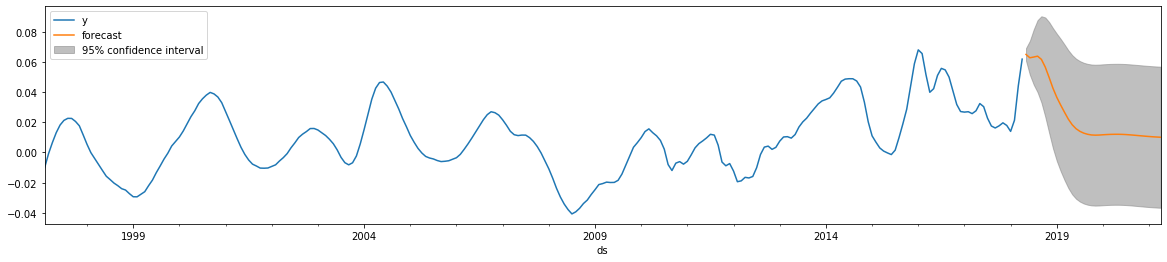

In [149]:
#plot of ARMA model
fig, ax = plt.subplots()
ax = logged_df_minus_roll_mean1.plot(ax=ax)
fig = ar.plot_predict('2018-05-01', '2021-04-01', dynamic=True, ax=ax, plot_insample=False)
plt.show()

Not much of a difference. Residuals barely changed. The price prediction looks like it might go lower. Good time to buy in a year.

In [146]:
#Future work, try SARIMAX prediction
# Need to install modules properly for SARIMAX to work.